In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
import csv
from ml.nodes import *
from ml.traces import *
from ml.misc import *
from sklearn.decomposition import FastICA, PCA

In [2]:
ds = Cifar10()

                                 Cifar10:        0     N:-1 C:3072 


In [3]:
sess = tf.InteractiveSession()

In [4]:
x = ds.x
y_ = ds.y_

In [5]:
d = Reshape(ds, 'C', 'CHW', (3, 32, 32))
x_im = Transpose(d, 'NHWC')
c = Conv2dI(x_im, 5)
s = Reshape(c, 'C', 'YXC', (5, 5, 3))

                                 Reshape:        0     N:-1 C:3 H:32 W:32 
                               Transpose:        0     N:-1 H:32 W:32 C:3 
                                 Conv2dI:     5625     N:-1 H:28 W:28 C:75 
                                 Reshape:        0     N:-1 H:28 W:28 Y:5 X:5 C:3 


In [6]:
sess.run(tf.global_variables_initializer())

In [7]:
n = 10
batch = ds.train.next_batch(n*n)
vals, v = sess.run((s.out(), x_im.out()), feed_dict={x: batch[0], y_: batch[1]})

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


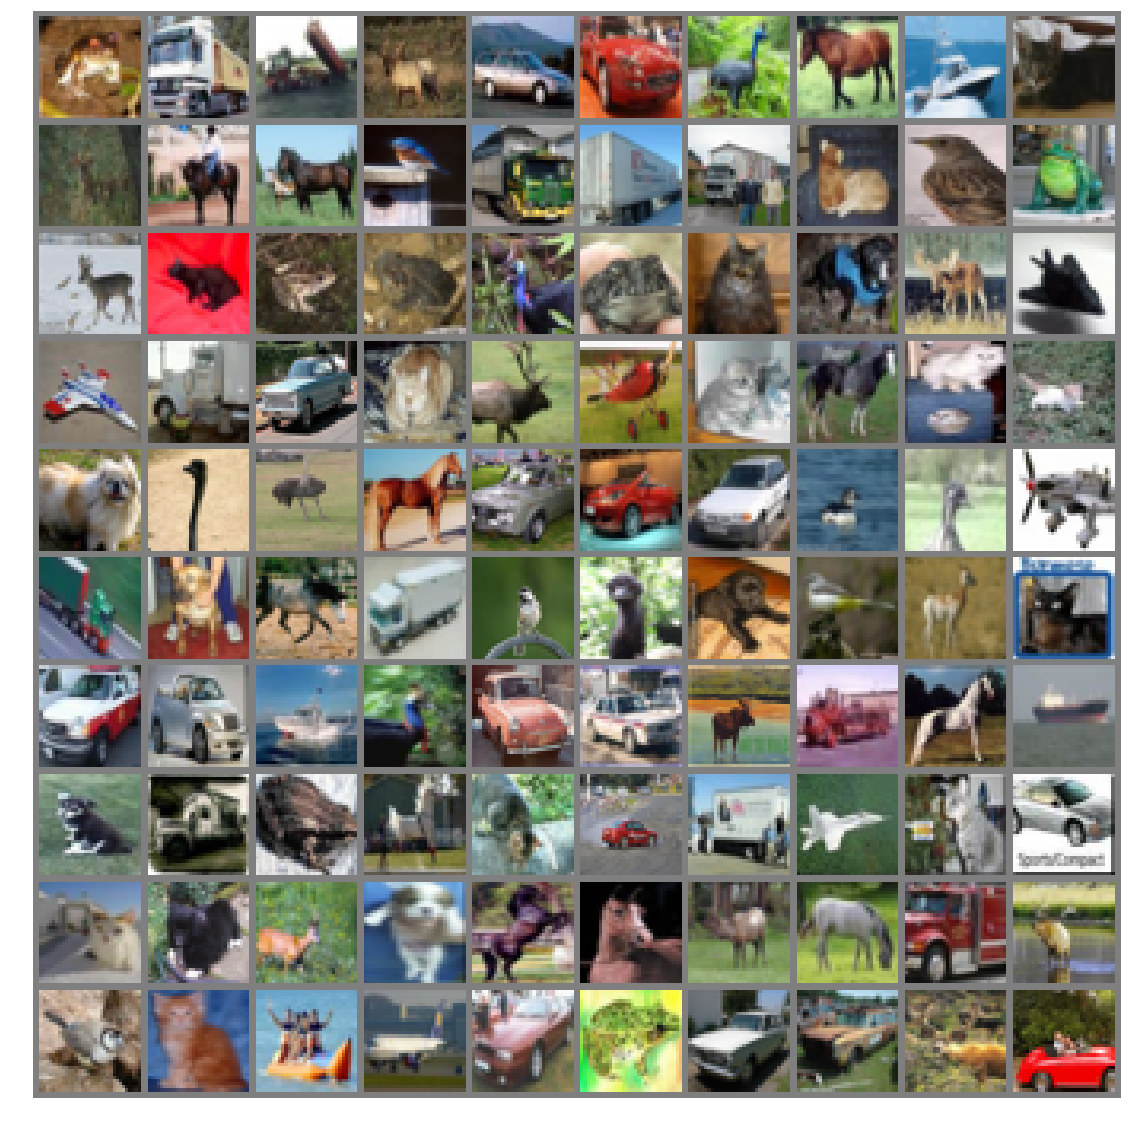

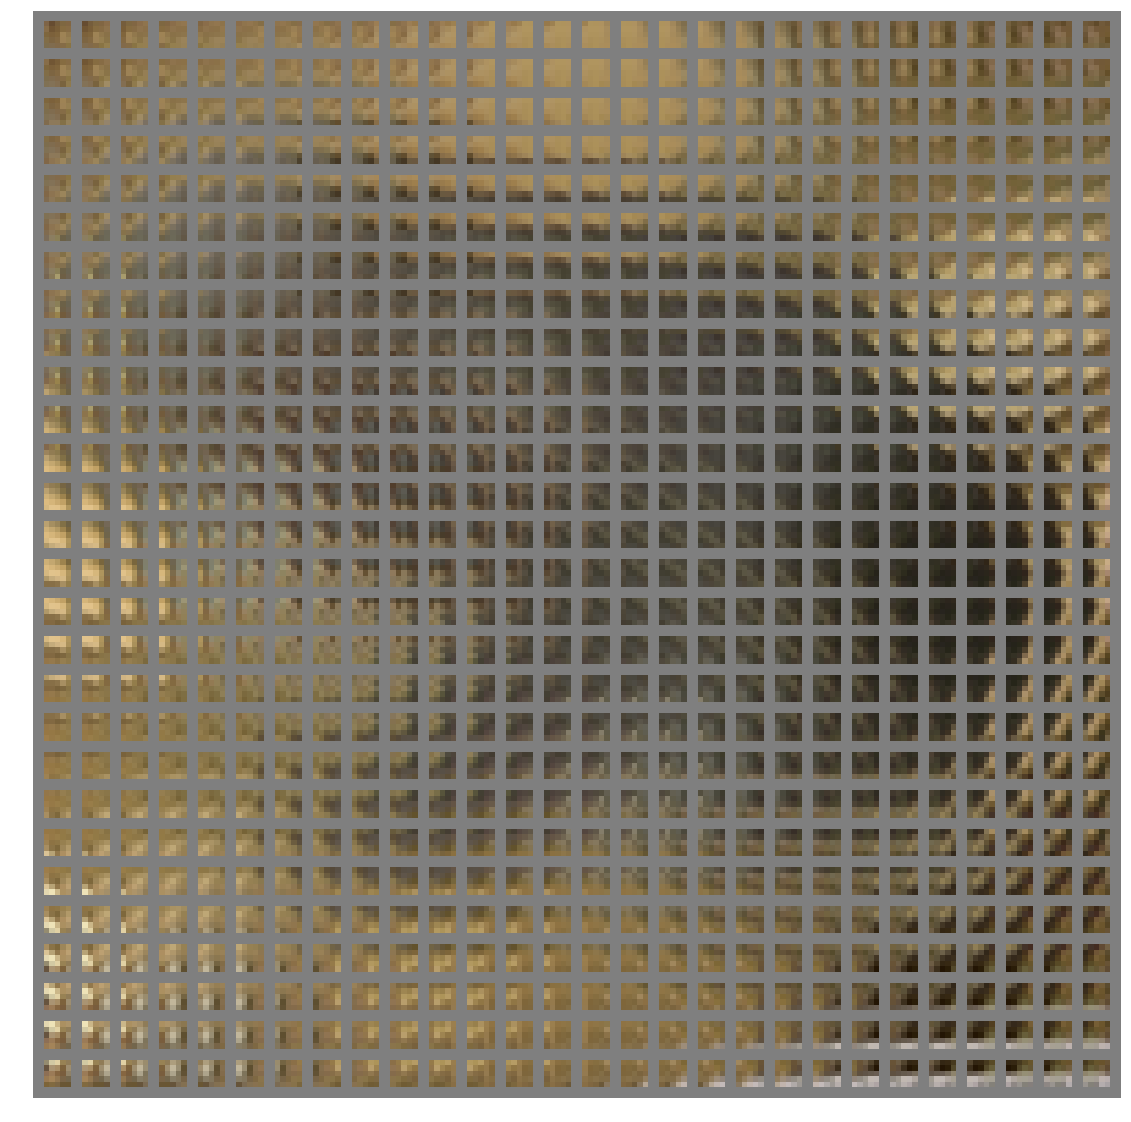

In [8]:
print batch[1][:10]
v = v.reshape((1, n, n, 32, 32, 3))
show(v, s.format())
vv = vals[23:24, :, :, :, :, :]
show(vv, s.format())

In [17]:
vals.shape
print np.mean(vals, axis=(0,1,2)).shape
print np.std(vals, axis=(0,1,2)).shape

(5, 5, 3)
(5, 5, 3)
